In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa

import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
import keras
import warnings
from keras.utils import Sequence
import tensorflow as tf
warnings.filterwarnings("ignore")
SIZE = 299
SEED = 777
THRESHOLD = 0.2

Using TensorFlow backend.


In [3]:
# Load dataset info
DIR = '../input/'
data = pd.read_csv('../input/train.csv')

# train_dataset_info = []
# for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
#     train_dataset_info.append({
#         'path':os.path.join(path_to_train, name),
#         'labels':np.array([int(label) for label in labels])})
# train_dataset_info = np.array(train_dataset_info)

In [4]:
def getTrainDataset():
    
    path_to_train = DIR + '/train/'
    data = pd.read_csv(DIR + '/train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR + '/test/'
    data = pd.read_csv(DIR + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)
paths, labels = getTrainDataset()

In [5]:
# credits: https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
# credits: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
from random import randint
class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, channels = [], shuffle = False, use_cache = False, augmentor = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.channels = channels
        self.augmentor = augmentor
        self.clahe = cv2.createCLAHE()
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], len(channels)))
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)
        if self.augmentor == True:
            for i, item in enumerate(X):
                X[i] = self.augment(item)
        y = self.labels[indexes]
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        images = []
        for channel in self.channels:
            im = np.array(Image.open(path + '_' + channel + '.png'))
            
#             im = clahe.apply(im)
            images.append(im)
            
        if len(self.channels) >= 2:
            im = np.stack((
                images
            ), -1)
            im = cv2.resize(im, (SIZE,SIZE))
            im = np.divide(im, 255)

        else:
            im = images[0]
            im = cv2.resize(im, (SIZE,SIZE))
            im = np.divide(im, 255)
            im = np.expand_dims(im, 2)
        return im
    def augment(self, image):
        if randint(0,1) == 1:
            augment_img = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Flipud(0.5), # horizontal flips
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                        rotate=(-180, 180),
                        shear=(-4, 4)
                    )
                ])], random_order=True)


            image_aug = augment_img.augment_image(image)
            return image_aug
        else:
            return image
    

In [6]:
SHAPE = (299, 299, 4)

In [7]:
channels = ["red"]
for path in paths[0:10]:
    images = []
    for channel in channels:
        print(channel)
        images.append(np.array(Image.open(path + '_' + channel + '.png')))

    if len(channels) >= 2:
        im = np.stack((
            images
        ), -1)
        im = cv2.resize(im, (SIZE,SIZE))
        im = np.divide(im, 255)
        
    else:
        im = images[0]
        im = cv2.resize(im, (SIZE,SIZE))
        im = np.divide(im, 255)
        im = np.expand_dims(im, 2)
    print(im.shape)

red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)
red
(299, 299, 1)


In [8]:

# class data_generator:
    
#     def create_train(dataset_info, batch_size, shape, augument=True):
#         assert shape[2] == 3
#         while True:
#             dataset_info = shuffle(dataset_info)
#             for start in range(0, len(dataset_info), batch_size):
#                 end = min(start + batch_size, len(dataset_info))
#                 batch_images = []
#                 X_train_batch = dataset_info[start:end]
#                 batch_labels = np.zeros((len(X_train_batch), 28))
#                 for i in range(len(X_train_batch)):
#                     image = data_generator.load_image(
#                         X_train_batch[i]['path'], shape)   
#                     if augument:
#                         image = data_generator.augment(image)
#                     batch_images.append(image/255.)
#                     batch_labels[i][X_train_batch[i]['labels']] = 1
#                 yield np.array(batch_images, np.float32), batch_labels

#     def load_image(path, shape):
#         image_red_ch = Image.open(path+'_red.png')
#         image_yellow_ch = Image.open(path+'_yellow.png')
#         image_green_ch = Image.open(path+'_green.png')
#         image_blue_ch = Image.open(path+'_blue.png')
#         image = np.stack((
#         np.array(image_red_ch), 
#         np.array(image_green_ch), 
#         np.array(image_blue_ch)), -1)
#         image = cv2.resize(image, (shape[0], shape[1]))
#         return image

#     def augment(image):
#         augment_img = iaa.Sequential([
#             iaa.OneOf([
#                 iaa.Affine(rotate=0),
#                 iaa.Affine(rotate=90),
#                 iaa.Affine(rotate=180),
#                 iaa.Affine(rotate=270),
#                 iaa.Fliplr(0.5),
#                 iaa.Flipud(0.5),
#             ])], random_order=True)

#         image_aug = augment_img.augment_image(image)
#         return image_aug

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization, Input, Conv2D, MaxPooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model
from keras.utils import multi_gpu_model

In [10]:
def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)
def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

In [11]:
# import h5py
# f = h5py.File("inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5", 'r')
# dset = f["conv2d_1"]
# list(dset.keys())
# group = dset["conv2d_1"]
# list(group.keys())
# first_lay = group['kernel:0'].value
# print(first_lay.shape)
# f.close()

In [12]:
# zeros = np.zeros(shape = (3,3,1,32))
# print(zeros.shape)
# first_lay1 = np.concatenate([zeros, first_lay], axis = 2)
# first_lay.shape
# f = h5py.File("inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5", 'r+')
# dset = f["conv2d_1"]
# list(dset.keys())
# group = dset["conv2d_1"]
# list(group.keys())
# del group['kernel:0']
# group['kernel:0'] = first_lay1
# f.close()

In [13]:
K.clear_session()
# -*- coding: utf-8 -*-
"""Inception V3 model for Keras.
Note that the input image format for this model is different than for
the VGG16 and ResNet models (299x299 instead of 224x224),
and that the input preprocessing function is also different (same as Xception).
# Reference
- [Rethinking the Inception Architecture for Computer Vision](http://arxiv.org/abs/1512.00567)
"""
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np

from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.preprocessing import image


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
    """Utility function to apply conv + BN.
    Arguments:
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
    Returns:
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x


def InceptionV3(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000):
    """Instantiates the Inception v3 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    Note that the default input image size for this model is 299x299.
    Arguments:
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)` (with `channels_last` data format)
            or `(3, 299, 299)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 139.
            E.g. `(150, 150, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    Returns:
        A Keras model instance.
    Raises:
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = (299,299,4)
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = Input(tensor=input_tensor, shape=input_shape)

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0, 1, 2: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    # mixed 1: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    # mixed 2: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate(
        [branch3x3, branch7x7x3, branch_pool], axis=channel_axis, name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2], axis=channel_axis, name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i))
    if include_top:
        # Classification block
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='inception_v3')

    # load weights
    if weights == 'imagenet':
        if K.image_data_format() == 'channels_first':
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
        if include_top:
            weights_path = get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='9a0d58056eeedaa3f26cb7ebd46da564')
        else:
            weights_path = get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='bcbd6486424b2319ff4ef7d526e38f63')
            weights_path = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            convert_all_kernels_in_model(model)
    return model
if __name__ == '__main__':
    model = InceptionV3(include_top=False, weights='imagenet')
    model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 1152        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
def create_model(input_shape, n_out, channels):
    input_tensor = Input(shape=(299,299,len(channels)))
    bn = BatchNormalization()(input_tensor)
    base_model = InceptionV3(include_top=False, weights='imagenet')
    x = base_model(bn)
    x = Dropout(0.5)(x)
    x = Conv2D(128, kernel_size=(3,3), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [15]:

channels = ["green", "blue", "red", "yellow"]
# with tf.device('/cpu:0'):
model = create_model(
    input_shape=(SIZE,SIZE,4), 
    n_out=28, channels = channels)
model.compile(
    loss="binary_crossentropy", 
    optimizer=Adam(1e-04),
    metrics=['acc', f1])
model.summary()

# model.layers[3].layers[1] = Conv2D(32, kernel_size = (7,7), strides = (2,2), padding = "same", input_shape = (299, 299, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 4)       0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 299, 299, 4)       16        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21803072  
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 2048)        0         
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 6, 6, 128)         2359424   
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4608)              0         
__________

In [16]:
# create callbacks list
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

epochs = 10; batch_size = 32;VAL_RATIO = .1;DEBUG = False
# split data into train, valid
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

if DEBUG == True:  # use only small subset for debugging, Kaggle's RAM is limited
    pathsTrain = paths[0:256]
    labelsTrain = labels[0:256]
    pathsVal = paths[lastTrainIndex:lastTrainIndex+256]
    labelsVal = labels[lastTrainIndex:lastTrainIndex+256]
    use_cache = True
else:
    pathsTrain = paths[0:lastTrainIndex]
    labelsTrain = labels[0:lastTrainIndex]
    pathsVal = paths[lastTrainIndex:]
    labelsVal = labels[lastTrainIndex:]
    use_cache = False

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)
use_cache = True
tg = ProteinDataGenerator(pathsTrain, labelsTrain, batch_size, SHAPE, channels, use_cache=use_cache)
vg = ProteinDataGenerator(pathsVal, labelsVal, batch_size, SHAPE, channels, use_cache=use_cache)

(31072,) (31072, 28)
(27964,) (27964, 28) (3108,) (3108, 28)


In [17]:
# create train and valid datagens
# train_generator = data_generator.create_train(
#     train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
# validation_generator = data_generator.create_train(
#     train_dataset_info[valid_indexes], 32, (SIZE,SIZE,3), augument=False)

In [18]:
checkpoint = ModelCheckpoint('../working/InceptionV3+branch.h5', monitor='val_f1', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = False)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_f1', factor=0.5, patience=10, 
                                   verbose=1, mode='max', epsilon=0.0001)
early = EarlyStopping(monitor="val_f1", 
                      mode="max", 
                      patience=20)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [19]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        pt_1 = K.clip(pt_1, 1e-3, .999)
        pt_0 = K.clip(pt_0, 1e-3, .999)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [25]:
# warm up model
import tensorflow as tf
channels = ["green", "blue", "red", "yellow"]
# with tf.device('/cpu:0'):
model = create_model(
    input_shape=(SIZE,SIZE,4), 
    n_out=28, channels = channels)

for layer in model.layers:
    layer.trainable = False
model.layers[0].trainable = True
model.layers[1].trainable = True
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
model.layers[-4].trainable = True
model.layers[-5].trainable = True
model.layers[-6].trainable = True
model.layers[-7].trainable = True

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 299, 299, 4)       0         
_________________________________________________________________
batch_normalization_285 (Bat (None, 299, 299, 4)       16        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21803072  
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 2048)        0         
_________________________________________________________________
conv2d_379 (Conv2D)          (None, 6, 6, 128)         2359424   
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 4608)              0         
__________

In [26]:

tg = ProteinDataGenerator(pathsTrain, labelsTrain, batch_size, SHAPE, channels, use_cache=use_cache)
vg = ProteinDataGenerator(pathsVal, labelsVal, batch_size, SHAPE, channels, use_cache=use_cache)

MemoryError: 

In [27]:
model.compile(loss="binary_crossentropy",
            optimizer=Adam(lr=1e-4),
            metrics=['accuracy', f1])

In [28]:
hist =  model.fit_generator(
        tg,
        steps_per_epoch=np.ceil(float(len(pathsTrain)) / float(batch_size))/2,
        validation_data=vg,
        validation_steps=np.ceil(float(len(pathsVal)) / float(batch_size))/2,
        epochs=20, 
        verbose=1,
        callbacks = callbacks_list)

Epoch 1/20
437/437 [==============================] - 739s 2s/step - loss: 0.2138 - acc: 0.9321 - f1: 0.0587 - val_loss: 0.1960 - val_acc: 0.9400 - val_f1: 0.0583

Epoch 00001: val_f1 improved from -inf to 0.05826, saving model to ../working/InceptionV3+branch.h5
Epoch 2/20
437/437 [==============================] - 709s 2s/step - loss: 0.1882 - acc: 0.9387 - f1: 0.0532 - val_loss: 0.2411 - val_acc: 0.9401 - val_f1: 0.0892

Epoch 00002: val_f1 improved from 0.05826 to 0.08916, saving model to ../working/InceptionV3+branch.h5
Epoch 3/20
437/437 [==============================] - 152s 347ms/step - loss: 0.1839 - acc: 0.9399 - f1: 0.0528 - val_loss: 0.2327 - val_acc: 0.9399 - val_f1: 0.0874

Epoch 00003: val_f1 did not improve from 0.08916
Epoch 4/20
437/437 [==============================] - 207s 473ms/step - loss: 0.1827 - acc: 0.9398 - f1: 0.0518 - val_loss: 0.2059 - val_acc: 0.9385 - val_f1: 0.0745

Epoch 00004: val_f1 did not improve from 0.08916
Epoch 5/20
437/437 [=================

In [29]:
for layer in model.layers:
    print(layer)
    layer.trainable = False
model.layers[2].layers[1].trainable = True
batch_size = 12
hist =  model.fit_generator(
        tg,
        steps_per_epoch=np.ceil(float(len(pathsTrain)) / float(batch_size))/2,
        validation_data=vg,
        validation_steps=np.ceil(float(len(pathsVal)) / float(batch_size))/2,
        epochs=100, 
        verbose=1,
        callbacks=callbacks_list)

Epoch 1/100
1166/1165 [==============================] - 528s 452ms/step - loss: 0.1651 - acc: 0.9428 - f1: 0.0750 - val_loss: 0.2087 - val_acc: 0.9234 - val_f1: 0.0739

Epoch 00001: val_f1 did not improve from 0.09042
Epoch 2/100
1166/1165 [==============================] - 450s 386ms/step - loss: 0.1631 - acc: 0.9434 - f1: 0.0808 - val_loss: 0.2173 - val_acc: 0.9320 - val_f1: 0.0794

Epoch 00002: val_f1 did not improve from 0.09042
Epoch 3/100
1166/1165 [==============================] - 409s 351ms/step - loss: 0.1618 - acc: 0.9436 - f1: 0.0869 - val_loss: 0.2148 - val_acc: 0.9297 - val_f1: 0.0788

Epoch 00003: val_f1 did not improve from 0.09042
Epoch 4/100
1166/1165 [==============================] - 462s 396ms/step - loss: 0.1593 - acc: 0.9440 - f1: 0.0950 - val_loss: 0.2137 - val_acc: 0.9281 - val_f1: 0.0785

Epoch 00004: val_f1 did not improve from 0.09042
Epoch 5/100
1166/1165 [==============================] - 435s 373ms/step - loss: 0.1573 - acc: 0.9446 - f1: 0.1044 - val_los

KeyboardInterrupt: 

In [30]:
# train all layers

for layer in model.layers:
    print(layer)
    layer.trainable = True
model.compile(loss="binary_crossentropy",
            optimizer=Adam(lr=1e-4),
            metrics=['accuracy', f1])
batch_size = 12
hist =  model.fit_generator(
        tg,
        steps_per_epoch=np.ceil(float(len(pathsTrain)) / float(batch_size))/2,
        validation_data=vg,
        validation_steps=np.ceil(float(len(pathsVal)) / float(batch_size))/2,
        epochs=100, 
        verbose=1,
        callbacks=callbacks_list)

Epoch 1/100
1166/1165 [==============================] - 577s 495ms/step - loss: 0.1749 - acc: 0.9413 - f1: 0.0726 - val_loss: 0.1802 - val_acc: 0.9408 - val_f1: 0.0840

Epoch 00001: val_f1 did not improve from 0.09042
Epoch 2/100
1166/1165 [==============================] - 551s 473ms/step - loss: 0.1668 - acc: 0.9432 - f1: 0.0729 - val_loss: 0.1647 - val_acc: 0.9448 - val_f1: 0.1035

Epoch 00002: val_f1 improved from 0.09042 to 0.10347, saving model to ../working/InceptionV3+branch.h5
Epoch 3/100
1166/1165 [==============================] - 568s 487ms/step - loss: 0.1504 - acc: 0.9485 - f1: 0.1277 - val_loss: 0.1490 - val_acc: 0.9501 - val_f1: 0.1639

Epoch 00003: val_f1 improved from 0.10347 to 0.16387, saving model to ../working/InceptionV3+branch.h5
Epoch 4/100
1166/1165 [==============================] - 578s 495ms/step - loss: 0.1308 - acc: 0.9543 - f1: 0.1984 - val_loss: 0.1434 - val_acc: 0.9507 - val_f1: 0.1986

Epoch 00004: val_f1 improved from 0.16387 to 0.19855, saving mode

1166/1165 [==============================] - 597s 512ms/step - loss: 0.0019 - acc: 0.9995 - f1: 0.5555 - val_loss: 0.2803 - val_acc: 0.9573 - val_f1: 0.2590

Epoch 00033: val_f1 improved from 0.25512 to 0.25899, saving model to ../working/InceptionV3+branch.h5
Epoch 34/100
1166/1165 [==============================] - 527s 452ms/step - loss: 0.0011 - acc: 0.9997 - f1: 0.5586 - val_loss: 0.3091 - val_acc: 0.9569 - val_f1: 0.2572

Epoch 00034: val_f1 did not improve from 0.25899
Epoch 35/100
1166/1165 [==============================] - 524s 449ms/step - loss: 0.0011 - acc: 0.9997 - f1: 0.5575 - val_loss: 0.3154 - val_acc: 0.9572 - val_f1: 0.2572

Epoch 00035: val_f1 did not improve from 0.25899
Epoch 36/100
1166/1165 [==============================] - 563s 483ms/step - loss: 0.0012 - acc: 0.9997 - f1: 0.5583 - val_loss: 0.3158 - val_acc: 0.9570 - val_f1: 0.2565

Epoch 00036: val_f1 did not improve from 0.25899
Epoch 37/100
1166/1165 [==============================] - 525s 450ms/step - los

1166/1165 [==============================] - 540s 463ms/step - loss: 1.2304e-04 - acc: 1.0000 - f1: 0.5586 - val_loss: 0.3647 - val_acc: 0.9575 - val_f1: 0.2566

Epoch 00068: val_f1 did not improve from 0.26444
Epoch 69/100
1166/1165 [==============================] - 601s 516ms/step - loss: 8.8763e-05 - acc: 1.0000 - f1: 0.5609 - val_loss: 0.3674 - val_acc: 0.9575 - val_f1: 0.2558

Epoch 00069: val_f1 did not improve from 0.26444
Epoch 70/100
1166/1165 [==============================] - 562s 482ms/step - loss: 1.0476e-04 - acc: 1.0000 - f1: 0.5602 - val_loss: 0.3748 - val_acc: 0.9579 - val_f1: 0.2600

Epoch 00070: val_f1 did not improve from 0.26444
Epoch 71/100
1166/1165 [==============================] - 524s 450ms/step - loss: 1.2735e-04 - acc: 1.0000 - f1: 0.5612 - val_loss: 0.3717 - val_acc: 0.9571 - val_f1: 0.2612

Epoch 00071: val_f1 did not improve from 0.26444
Epoch 72/100
1166/1165 [==============================] - 837s 718ms/step - loss: 1.2002e-04 - acc: 1.0000 - f1: 0.55

In [ ]:
# model.compile(loss=f1_loss,
#             optimizer=Adam(lr=1e-4),
#             metrics=['accuracy', f1])
# hist =  model.fit_generator(
#         tg,
#         steps_per_epoch=np.ceil(float(len(pathsTrain)) / float(batch_size))/2,
#         validation_data=vg,
#         validation_steps=np.ceil(float(len(pathsVal)) / float(batch_size))/2,
#         epochs=200, 
#         verbose=1,
#         callbacks=callbacks_list)

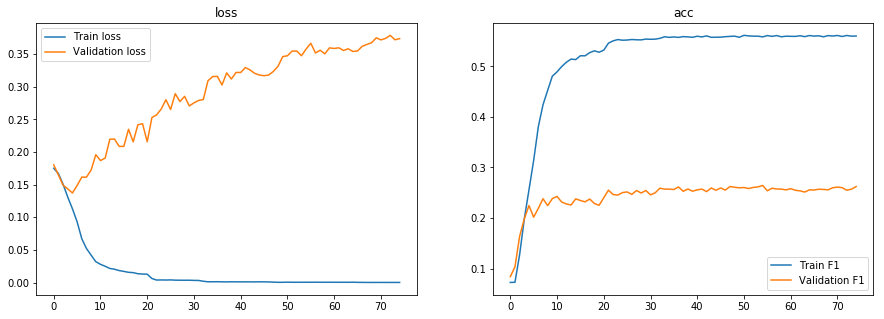

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [ ]:
from keras.models import load_model
bestModel = load_model('../working/InceptionV3.h5', custom_objects={'f1': f1, 'f1_loss': f1_loss, 'focal_loss_fixed':focal_loss()})

In [ ]:
from tqdm import tqdm
lastFullValPred = np.empty((0, 28))
lastFullValLabels = np.empty((0, 28))
for i in tqdm(range(len(vg))): 
    im, lbl = vg[i]
    scores = bestModel.predict(im)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
print(lastFullValPred.shape, lastFullValLabels.shape)

In [ ]:
from sklearn.metrics import f1_score as off1
rng = np.arange(0, 1, 0.001)
f1s = np.zeros((rng.shape[0], 28))
for j,t in enumerate(tqdm(rng)):
    for i in range(28):
        p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
        scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
        f1s[j,i] = scoref1

In [ ]:
print('Individual F1-scores for each class:')
print(np.max(f1s, axis=0))
print('Macro F1-score CV =', np.mean(np.max(f1s, axis=0)))
plt.plot(rng, f1s)
T = np.empty(28)
for i in range(28):
    T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
print('Probability threshold maximizing CV F1-score for each class:')
print(T)

In [ ]:
pathsTest, labelsTest = getTestDataset()

testg = ProteinDataGenerator(pathsTest, labelsTest, batch_size, SHAPE, channels)
submit = pd.read_csv(DIR + '/sample_submission.csv')
P = np.zeros((pathsTest.shape[0], 28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = bestModel.predict(images)
    P[i*batch_size:i*batch_size+score.shape[0]] = score

In [ ]:
PP = np.array(P)

In [ ]:
prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    
    for col in range(PP.shape[1]):
        if(PP[row, col] < T[col]):
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv('transfer_1x1conv_aug_focal_loss.csv', index=False)

In [ ]:
# from tqdm import tqdm
# pathsTest, labelsTest = getTestDataset()

# testg = ProteinDataGenerator(pathsTest, labelsTest, batch_size, SHAPE)
# submit = pd.read_csv(DIR + '/sample_submission.csv')
# P = np.zeros((pathsTest.shape[0], 28))
# for i in tqdm(range(len(testg))):
#     images, labels = testg[i]
#     score = bestModel.predict(images)
#     P[i*batch_size:i*batch_size+score.shape[0]] = score

In [ ]:
# PP = np.array(P)

In [ ]:
# prediction = []

# for row in tqdm(range(submit.shape[0])):
    
#     str_label = ''
    
#     for col in range(PP.shape[1]):
#         if(PP[row, col] < .2):   # to account for losing TP is more costly than decreasing FP
#             #print(PP[row])
#             str_label += ''
#         else:
#             str_label += str(col) + ' '
#     prediction.append(str_label.strip())
    
# submit['Predicted'] = np.array(prediction)
# submit.to_csv('datagenerator_model_v2.csv', index=False)